# Intoduction

In [3]:
!pip install opencv-python

# Import necessary packages

In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader,ConcatDataset
import glob   #for iterate on folder
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import cv2   # for image reading 
import sys

## Reading MRI images

In [2]:
tumor = []
for f in glob.iglob("./data/brain_tumor_dataset/yes/*.jpg"):
    img = cv2.imread(f)
    img = cv2.resize(img, (128,128))
    b, g ,r = cv2.split(img)
    img = cv2.merge([r, g, b])
    tumor.append(img)

healthy = []
for f in glob.iglob("./data/brain_tumor_dataset/no/*.jpg"):
    img = cv2.imread(f)
    img = cv2.resize(img, (128,128))
    b, g ,r = cv2.split(img)
    img = cv2.merge([r, g, b])
    healthy.append(img)
    

In [3]:
healthy = np.array(healthy)
tumor = np.array(tumor)
All = np.concatenate((healthy, tumor)) # merge tumor, healthy image data

In [4]:
print(tumor.shape)  #(no_of_data, rows, cols, No_of_channels)
print(healthy.shape)
All.shape

(154, 128, 128, 3)
(91, 128, 128, 3)


(245, 128, 128, 3)

In [5]:
np.random.choice(10,5, replace=False)

array([9, 2, 4, 3, 6])

# Visualizations Images

In [6]:
healthy[0].shape #shows the dimensions of 1st iamge fom healthy dataset

(128, 128, 3)

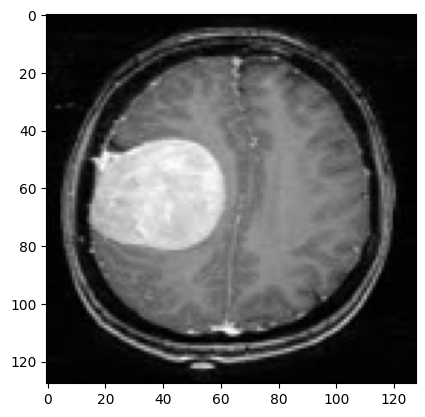

In [7]:
#visualize 1st image from tumor dataset
plt.imshow(tumor[0])

In [8]:
def plot_random(healthy, tumor, num=5):
    healthy_images = healthy[np.random.choice(healthy.shape[0],num, replace=False)]
    tumor_images = tumor[np.random.choice(tumor.shape[0],num, replace=False)]
    
    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title('healthy')
        plt.imshow(healthy_images[i])

    
    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title('tumor')
        plt.imshow(tumor_images[i])

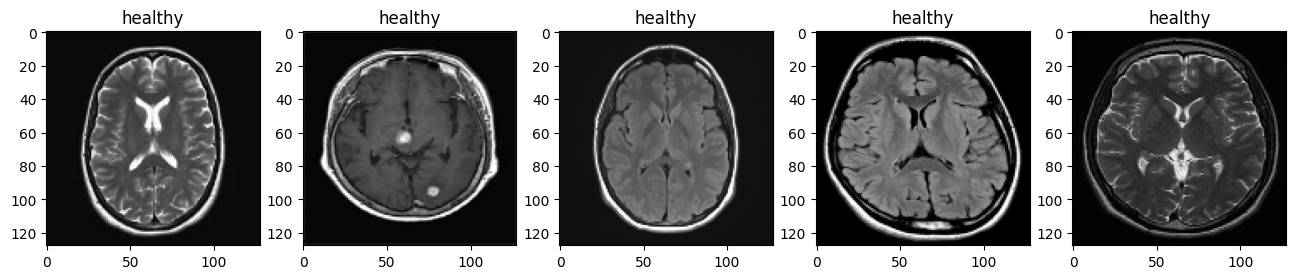

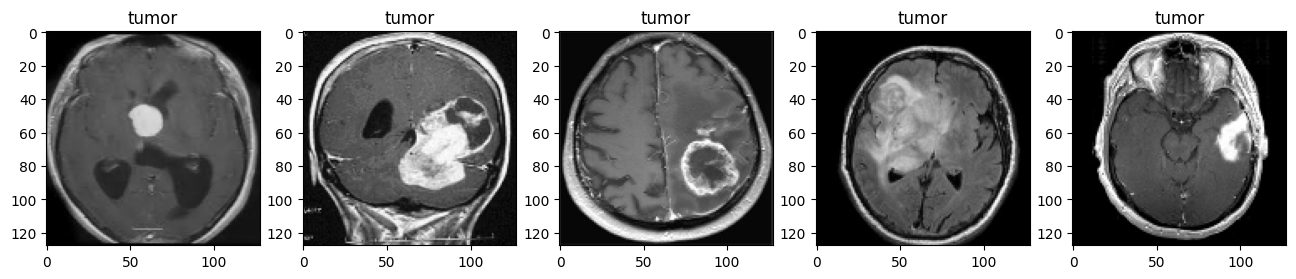

In [9]:
plot_random(healthy,tumor)

# PyTorch Class

## PyTorch Abstact Dataset Class

In [10]:
class Dataset(object):
    """ An Abstart class represeting a Dataset. All other datsets should subclass
    it. All subclass  should override ``__len__``, that provides the size of  dataset
    and ``__getitem__```, supporting integer indexing in range from 0 to len(self)
    exclusive """
    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])

In [11]:
class MRI(Dataset):
    def __init__(self):
        
        tumor = []
        healthy = []
        # cv2 - It reads in BGR format by default
        for f in glob.iglob("./data/brain_tumor_dataset/yes/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128)) # I can add this later in the boot-camp for more adventure
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1])) # otherwise the shape will be (h,w,#channels)
            tumor.append(img)

        for f in glob.iglob("./data/brain_tumor_dataset/no/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128)) 
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1]))
            healthy.append(img)

        # our images
        tumor = np.array(tumor,dtype=np.float32)
        healthy = np.array(healthy,dtype=np.float32)
        
        # our labels
        tumor_label = np.ones(tumor.shape[0], dtype=np.float32)
        healthy_label = np.zeros(healthy.shape[0], dtype=np.float32)
        
        # Concatenates
        self.images = np.concatenate((tumor, healthy), axis=0)
        self.labels = np.concatenate((tumor_label, healthy_label))
        
    def __len__(self):
        return self.images.shape[0]
    
    def __getitem__(self, index):
        
        sample = {'image': self.images[index], 'label':self.labels[index]}
        
        return sample
    
    def normalize(self):
        self.images = self.images/255.0

In [12]:
mri_dataset = MRI()
mri_dataset.normalize()

# DataLoader

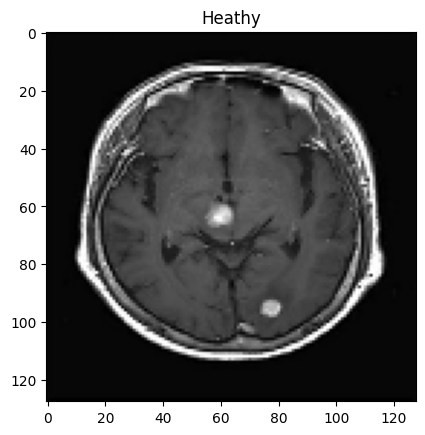

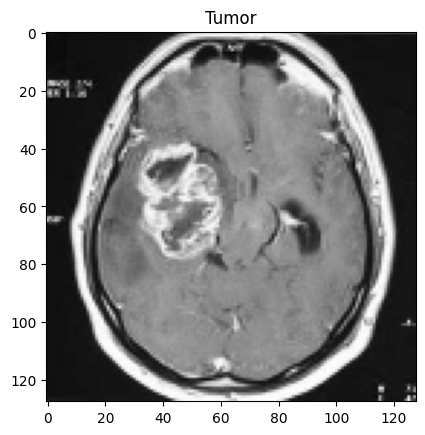

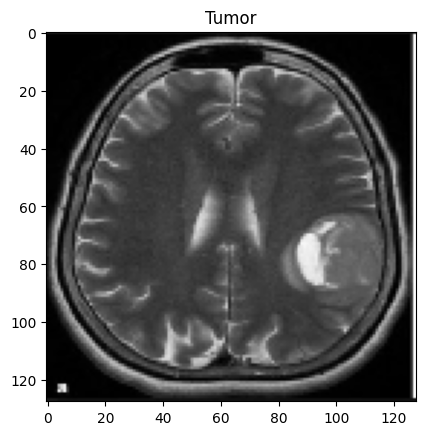

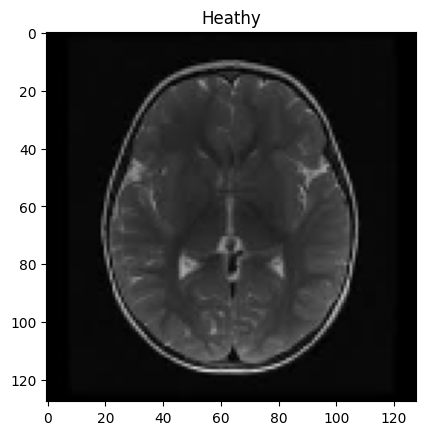

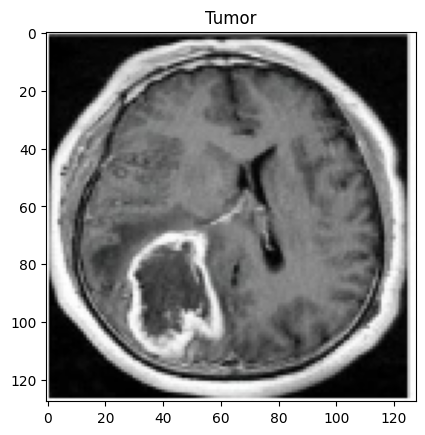

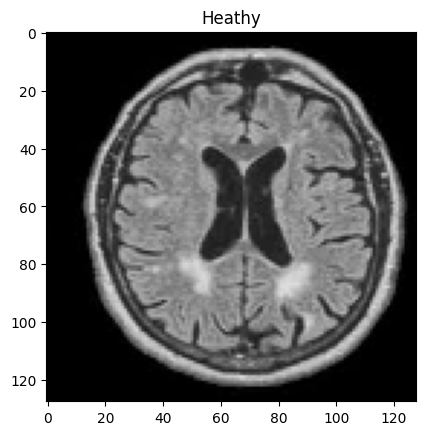

In [14]:
# One way of iterating
names={0:'Heathy', 1:'Tumor'}
dataloader = DataLoader(mri_dataset, shuffle=True)
for i, sample in enumerate(dataloader):
    img = sample['image'].squeeze()
    img = img.reshape((img.shape[1], img.shape[2], img.shape[0]))
    plt.title(names[sample['label'].item()])
    plt.imshow(img)
    plt.show()
    if i == 5:
        break

# Create Model

In [16]:
import torch.nn as nn
import torch.nn.functional as F 

In [17]:
class CNN(nn.Module):
    #constructor
    def __init__(self):
        super(CNN, self).__init__()
        self.cnn_model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5), #no_of input_channels, No_of_filters, kernel_size
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=5),
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=5))
        
        self.fc_model = nn.Sequential( #fully connected layer
        nn.Linear(in_features=256,out_features=120),
        nn.Tanh(),
        nn.Linear(in_features=120,out_features=84),
        nn.Tanh(),
        nn.Linear(in_features=84,out_features=1))
        
    #forward propagation
    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0),-1) #flatten the layer
        x = self.fc_model(x)
        x = F.sigmoid(x)
        
        return x 

In [18]:
model = CNN()

In [19]:
model

CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)

In [20]:
model.cnn_model

Sequential(
  (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): Tanh()
  (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): Tanh()
  (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
)

In [21]:
model.cnn_model[0].weight[0]

tensor([[[ 0.0762, -0.0293,  0.1104, -0.0031, -0.0285],
         [ 0.0189,  0.0902, -0.0791, -0.0921,  0.0321],
         [-0.0608, -0.0328, -0.0125,  0.0109, -0.0512],
         [-0.0217, -0.0986,  0.0386, -0.0719, -0.0866],
         [ 0.1002, -0.0587,  0.0171,  0.0846,  0.0266]],

        [[ 0.0745,  0.0338, -0.0235,  0.0229, -0.0159],
         [-0.0008,  0.1127,  0.1053, -0.0432,  0.0656],
         [-0.0608, -0.1044, -0.0971,  0.0366, -0.0766],
         [-0.0629, -0.0278,  0.0168,  0.0242, -0.0486],
         [ 0.0150,  0.0853,  0.1027,  0.0541,  0.0677]],

        [[-0.0035, -0.0364,  0.1032,  0.0604, -0.0400],
         [ 0.0196, -0.1006,  0.0126,  0.0908,  0.0994],
         [ 0.0493, -0.0111, -0.0101,  0.1017,  0.0713],
         [-0.0595, -0.0540, -0.1105, -0.0616,  0.0490],
         [-0.0668,  0.1148,  0.0232, -0.0960, -0.0475]]],
       grad_fn=<SelectBackward0>)

In [22]:
model.cnn_model[0].weight[0].shape

torch.Size([3, 5, 5])

In [23]:
model.cnn_model[0].weight[0][2]

tensor([[-0.0035, -0.0364,  0.1032,  0.0604, -0.0400],
        [ 0.0196, -0.1006,  0.0126,  0.0908,  0.0994],
        [ 0.0493, -0.0111, -0.0101,  0.1017,  0.0713],
        [-0.0595, -0.0540, -0.1105, -0.0616,  0.0490],
        [-0.0668,  0.1148,  0.0232, -0.0960, -0.0475]],
       grad_fn=<SelectBackward0>)

## Linear Layer

In [24]:
model.fc_model

Sequential(
  (0): Linear(in_features=256, out_features=120, bias=True)
  (1): Tanh()
  (2): Linear(in_features=120, out_features=84, bias=True)
  (3): Tanh()
  (4): Linear(in_features=84, out_features=1, bias=True)
)

In [25]:
model.fc_model[0]

Linear(in_features=256, out_features=120, bias=True)

In [26]:
model.fc_model[0].weight.shape

torch.Size([120, 256])

# Evaluate a New_Born Neural Net

In [27]:
mri_dataset = MRI()
mri_dataset.normalize()
device = torch.device('cpu:0')
model = CNN().to(device)

In [28]:
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)

In [29]:
model.eval()
output = []
y_true = []

with torch.no_grad():
    for D in dataloader:
        image = D['image'].to(device)
        label = D['label'].to(device)

        y_hat = model(image)
        output.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy()) #converting pytorch tensor to Numpy Array

In [30]:
outputs = np.concatenate(output, axis=0).squeeze()
y_true = np.concatenate(y_true, axis=0).squeeze()

In [31]:
def threshold(scores, threshold=0.50, minimum=0, maximum=1.0):
    x=np.array(list(scores))
    x[x >= threshold]=maximum
    x[x < threshold]=minimum
    return x

In [32]:
accuracy_score(y_true, threshold(outputs))

0.6285714285714286

[Text(0, 0.5, 'Tumor'), Text(0, 1.5, 'Healthy')]

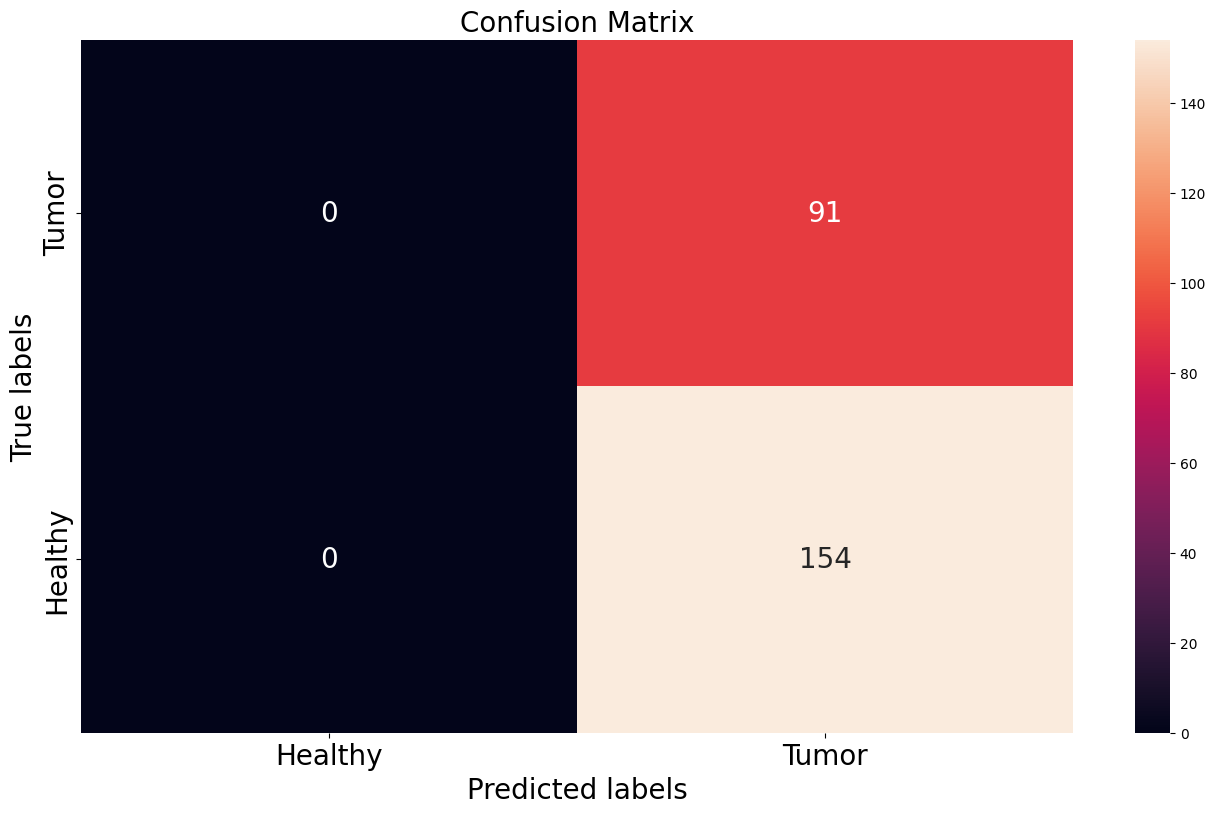

In [35]:
#Confusion Matrix 

import seaborn as sns

plt.figure(figsize=(16,9))
cm = confusion_matrix(y_true, threshold(outputs))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, annot_kws={"size": 20})

# labels, title and ticks
ax.set_xlabel('Predicted labels', fontsize=20)
ax.set_ylabel('True labels', fontsize=20) 
ax.set_title('Confusion Matrix', fontsize=20)
ax.xaxis.set_ticklabels(['Healthy','Tumor'], fontsize=20)
ax.yaxis.set_ticklabels(['Tumor','Healthy'], fontsize=20)

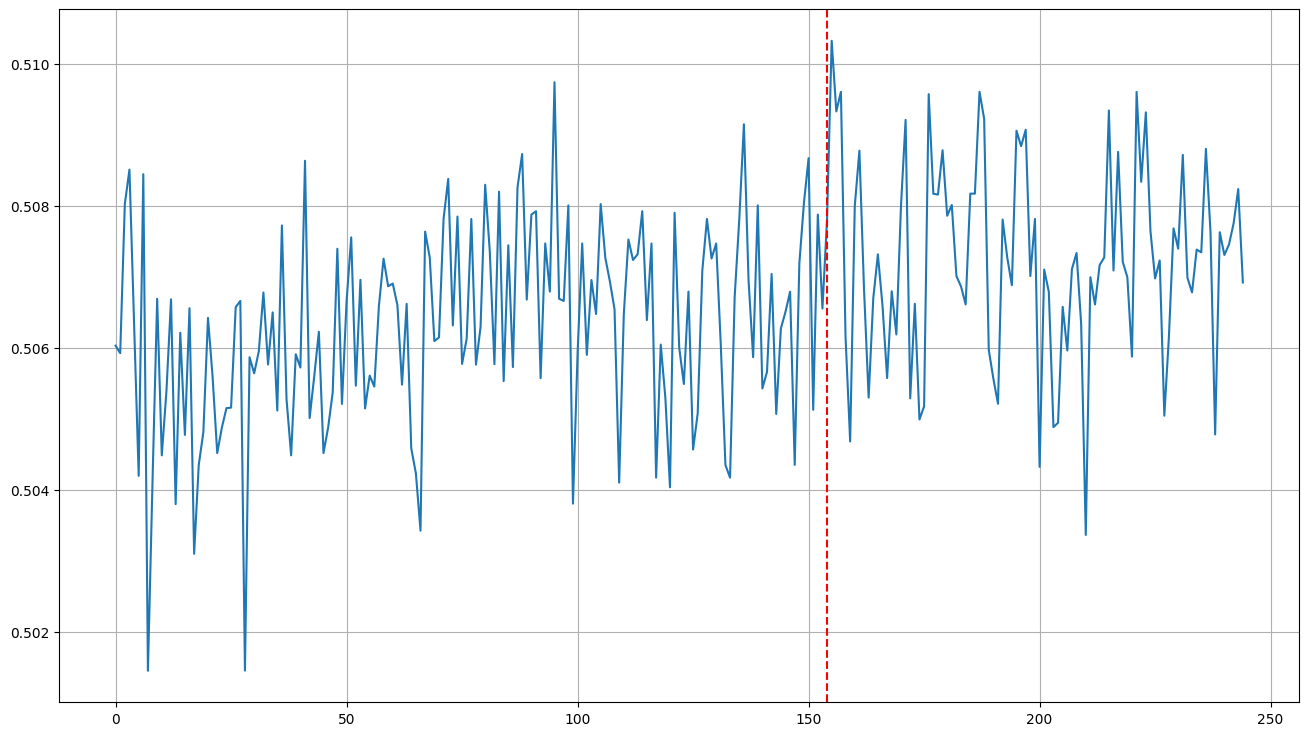

In [37]:
plt.figure(figsize=(16,9))
plt.plot(outputs)
plt.axvline(x=len(tumor), color='r', linestyle='--')
plt.grid()

# Train the model

In [40]:
eta = 0.0001
EPOCH = 400
optimizer = torch.optim.Adam(model.parameters(), lr=eta)
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=True)
model.train()

CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)

In [41]:
for epoch in range(1, EPOCH):
    losses = []
    for D in dataloader:
        optimizer.zero_grad()
        data = D['image'].to(device)
        label = D['label'].to(device)
        y_hat = model(data)
        
        #define loss function
        error = nn.BCELoss()
        loss = torch.sum(error(y_hat.squeeze(), label))
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    if(epoch+1) % 10 == 0:
        print('Train Epoch: {}\tLoss: {:.6f}'.format(epoch+1, np.mean(losses)))
        
    

Train Epoch: 10	Loss: 0.632242
Train Epoch: 20	Loss: 0.589352
Train Epoch: 30	Loss: 0.557625
Train Epoch: 40	Loss: 0.539301
Train Epoch: 50	Loss: 0.529051
Train Epoch: 60	Loss: 0.509192
Train Epoch: 70	Loss: 0.498501
Train Epoch: 80	Loss: 0.473254
Train Epoch: 90	Loss: 0.461231
Train Epoch: 100	Loss: 0.442880
Train Epoch: 110	Loss: 0.426808
Train Epoch: 120	Loss: 0.422472
Train Epoch: 130	Loss: 0.392326
Train Epoch: 140	Loss: 0.386571
Train Epoch: 150	Loss: 0.367523
Train Epoch: 160	Loss: 0.362069
Train Epoch: 170	Loss: 0.332963
Train Epoch: 180	Loss: 0.327862
Train Epoch: 190	Loss: 0.327743
Train Epoch: 200	Loss: 0.287796
Train Epoch: 210	Loss: 0.268544
Train Epoch: 220	Loss: 0.262712
Train Epoch: 230	Loss: 0.237600
Train Epoch: 240	Loss: 0.215246
Train Epoch: 250	Loss: 0.201060
Train Epoch: 260	Loss: 0.180304
Train Epoch: 270	Loss: 0.174682
Train Epoch: 280	Loss: 0.141028
Train Epoch: 290	Loss: 0.124706
Train Epoch: 300	Loss: 0.113573
Train Epoch: 310	Loss: 0.097937
Train Epoch: 320	

# Evaluate  the Trained Model

In [42]:
model.eval()
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)
outputs = []
y_true = []

with torch.no_grad():
    for D in dataloader:
        image = D['image'].to(device)
        label = D['label'].to(device)

        y_hat = model(image)
        outputs.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy()) #converting pytorch tensor to Numpy Array

outputs = np.concatenate(outputs, axis=0)
y_true = np.concatenate(y_true, axis=0)

In [43]:
accuracy_score(y_true, threshold(outputs))

1.0

In [44]:
from sklearn.metrics import f1_score
f1 = f1_score(y_true, threshold(outputs))
print(f'F1 Score: {f1:.2f}')

F1 Score: 1.00


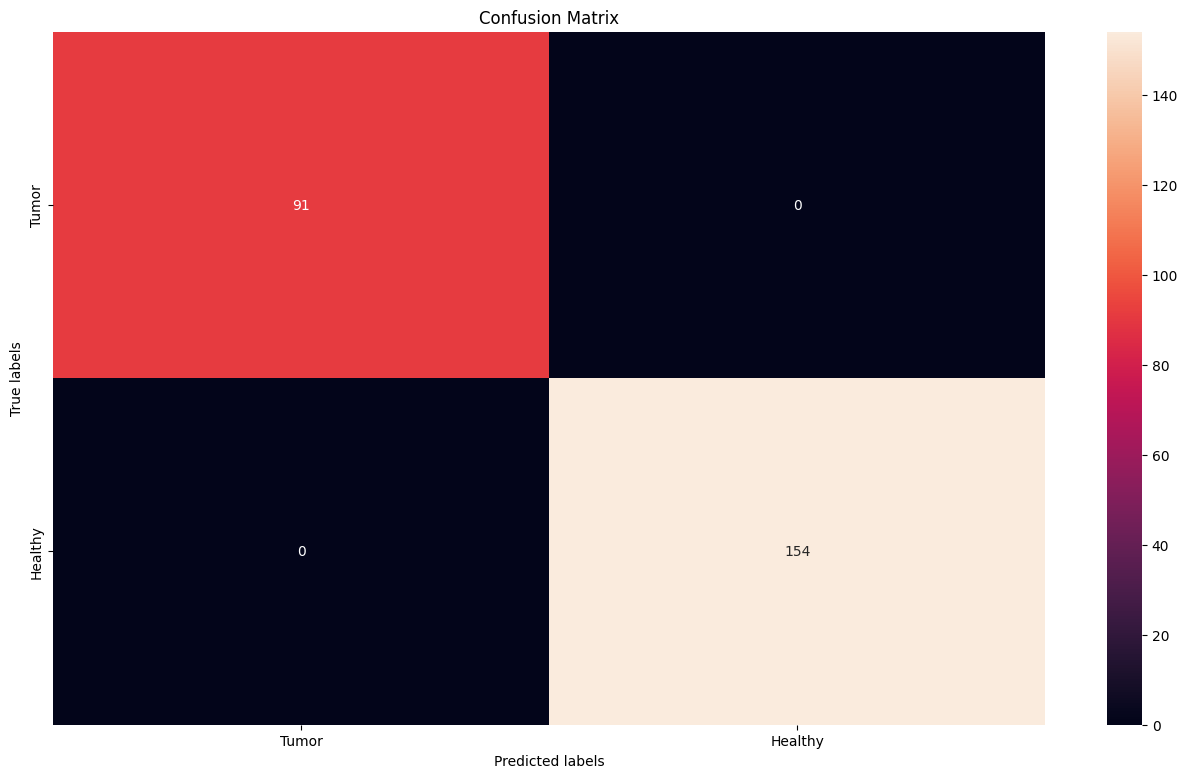

In [45]:
#Confusion Matrix of trained model

cm = confusion_matrix(y_true, threshold(outputs))
plt.figure(figsize=(16,9))

ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax); #annot = True to annotate cells, fmt='g' to diable scitific noation

# Labels, title, and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Tumor','Healthy']);
ax.yaxis.set_ticklabels(['Tumor', 'Healthy']);

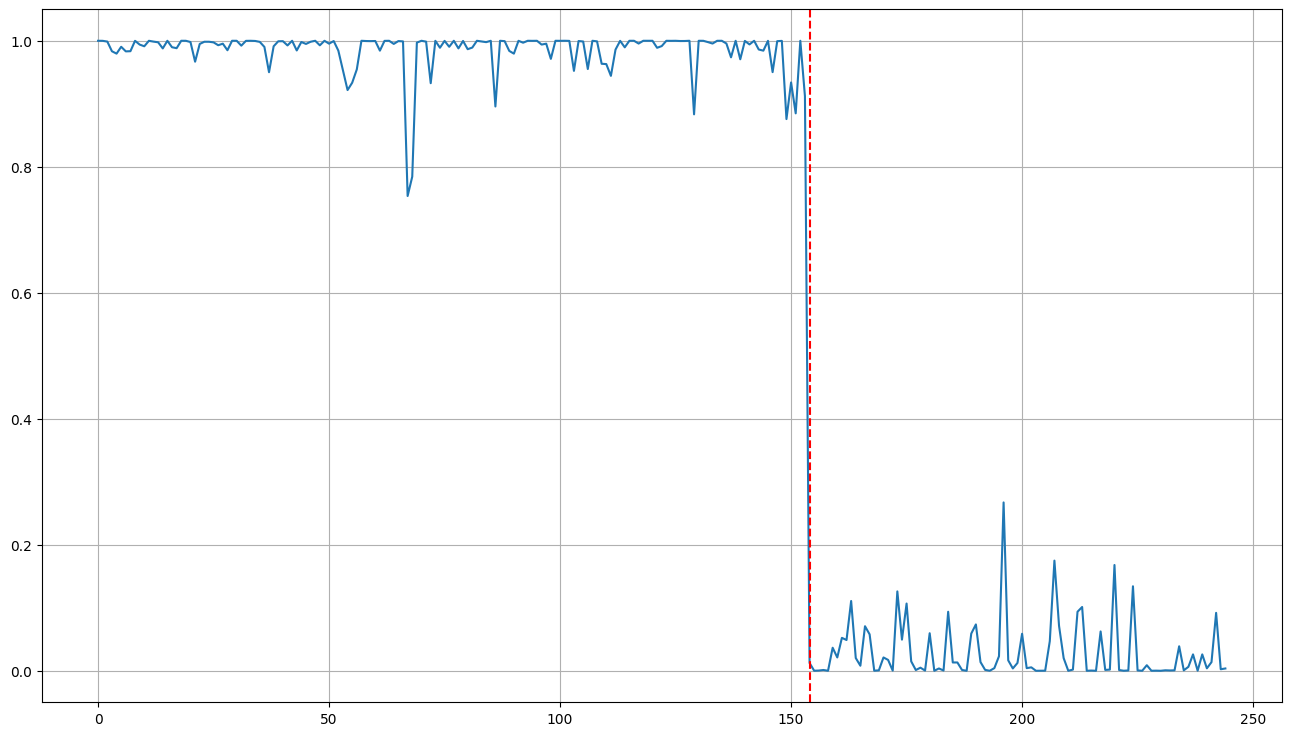

In [46]:
plt.figure(figsize=(16,9))
plt.plot(outputs)
plt.axvline(x=len(tumor), color='r', linestyle='--')
plt.grid()

# Visualising Feature Map of Convolution Filters

In [47]:
model

CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)

In [48]:
no_of_layers = 0
conv_layers = []

In [49]:
model_children = list (model.children())
model_children

[Sequential(
   (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
   (1): Tanh()
   (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
   (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
   (4): Tanh()
   (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
 ),
 Sequential(
   (0): Linear(in_features=256, out_features=120, bias=True)
   (1): Tanh()
   (2): Linear(in_features=120, out_features=84, bias=True)
   (3): Tanh()
   (4): Linear(in_features=84, out_features=1, bias=True)
 )]

In [50]:
for child in model_children:
    if type(child) == nn.Sequential:
        for layer in child.children():
            if type(layer) == nn.Conv2d:
                no_of_layers +=1
                conv_layers.append(layer)

In [51]:
conv_layers

[Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1)),
 Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))]

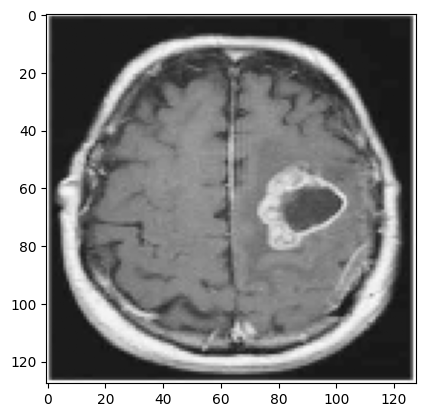

In [52]:
img = mri_dataset[100]['image']
plt.imshow(img.reshape(128,128,3))

In [53]:
img = torch.from_numpy(img).to(device)

In [54]:
img.shape

torch.Size([3, 128, 128])

In [55]:
img = img.unsqueeze(0)
img.shape

torch.Size([1, 3, 128, 128])

In [56]:
results = [conv_layers[0](img)]
for i in range(1, len(conv_layers)):
    results.append(conv_layers[i](results[-1]))
outputs = results

In [57]:
len(outputs)

2

In [58]:
outputs[1].shape

torch.Size([1, 16, 120, 120])

In [59]:
model

CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)

Layer 1


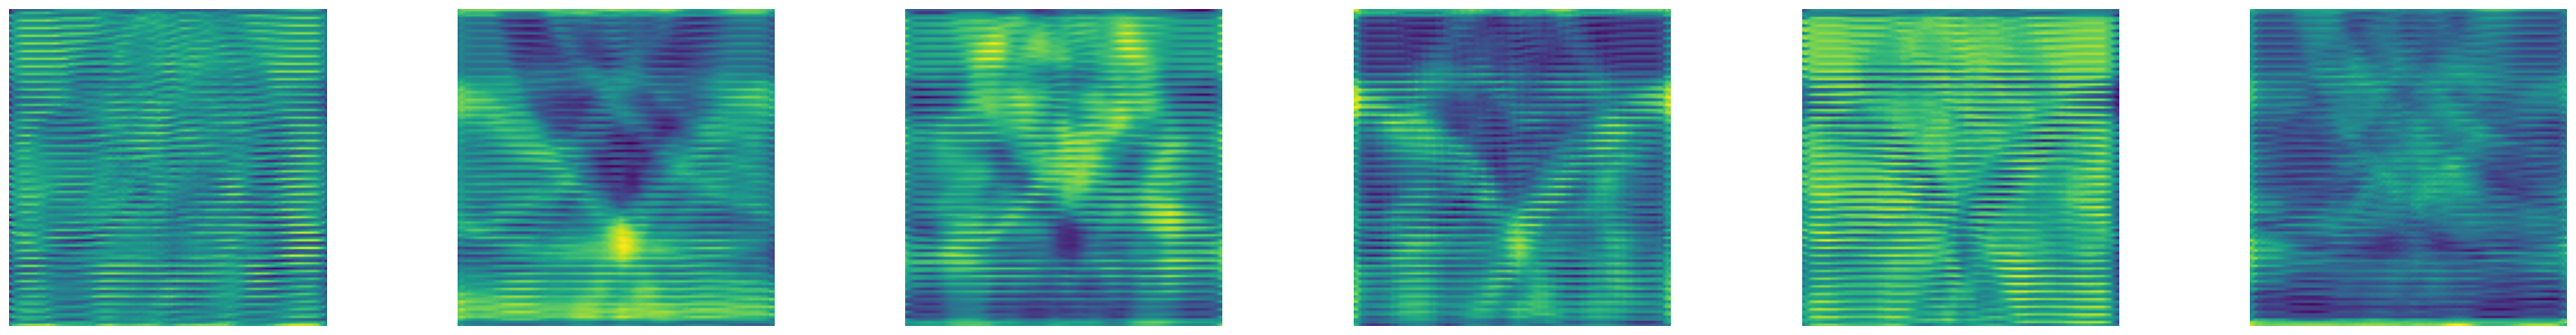

Layer 2


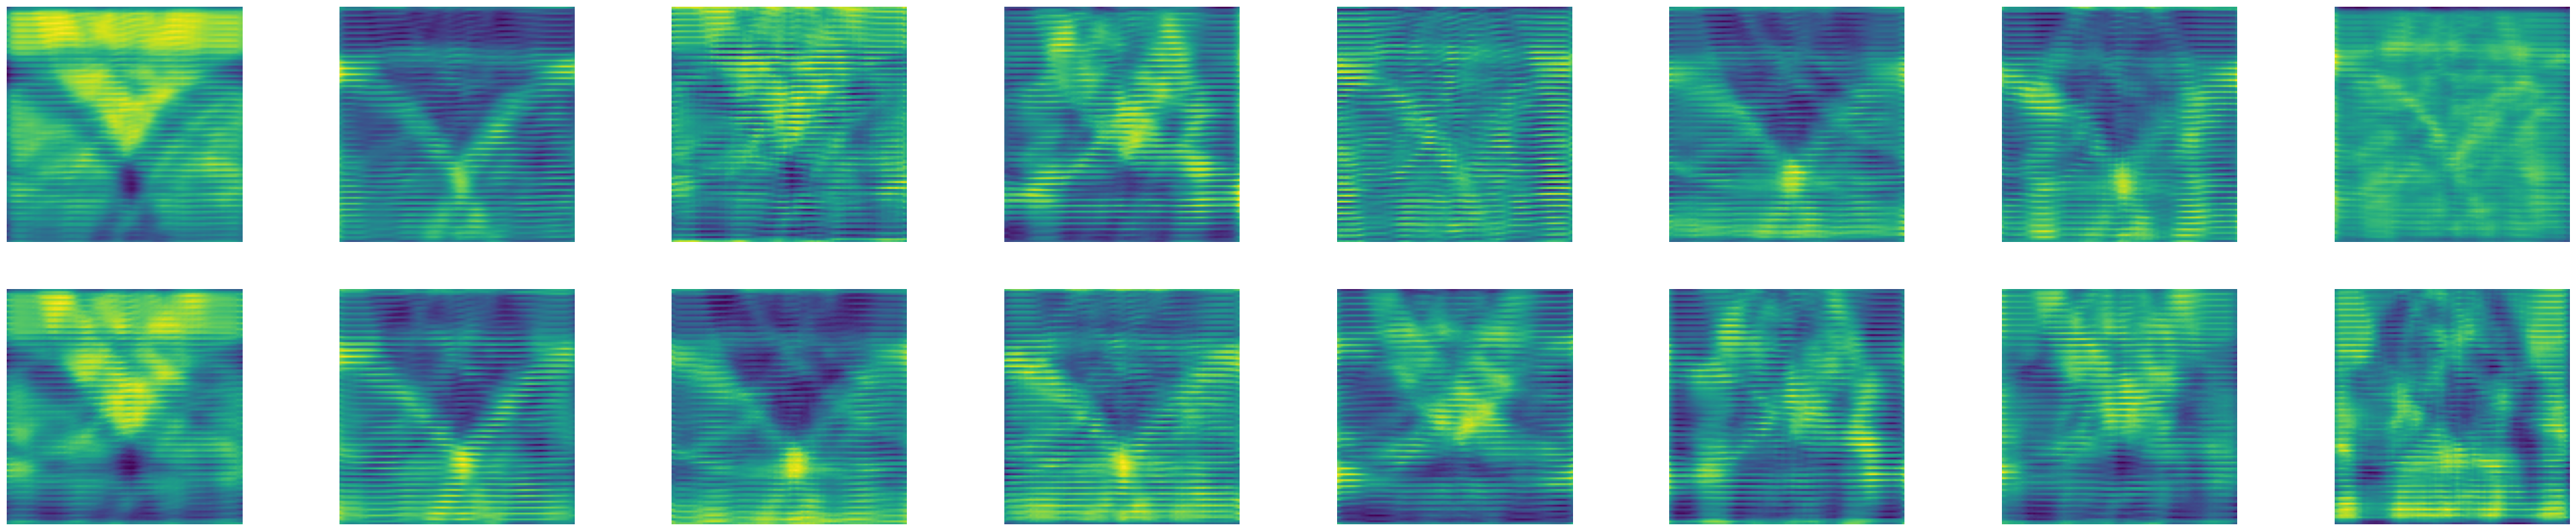

In [60]:
for num_layer in range(len(outputs)):
    plt.figure(figsize=(50, 10))
    layer_viz = outputs[num_layer].squeeze()
    print("Layer", num_layer+1)

    for i, f in enumerate(layer_viz):
        plt.subplot(2, 8, i + 1)
        plt.imshow(f.detach().cpu().numpy())
        plt.axis("off")

    plt.show()
    plt.close()

# Preparing Validation Set

In [61]:
from sklearn.model_selection import train_test_split

In [62]:
class MRI(Dataset):
    
    def __init__(self):
        
        # Variables to hold the Training data and Validation data
        self.X_train, self.y_train, self.X_val, self.y_val = None, None, None, None
        
        # A variable to determine if we are interested in retrieving the training OR the validation data
        self.mode = 'train'
        
        tumor = []
        healthy = []
        # cv2 - It reads in BGR format by default
        for f in glob.iglob("./data/brain_tumor_dataset/yes/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128)) # I can add this later in the boot-camp for more adventure
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1])) # otherwise the shape will be (h,w,#channels)
            tumor.append(img)

        for f in glob.iglob("./data/brain_tumor_dataset/no/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128)) 
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1]))
            healthy.append(img)

        # our images
        tumor = np.array(tumor,dtype=np.float32)
        healthy = np.array(healthy,dtype=np.float32)
        
        # our labels
        tumor_label = np.ones(tumor.shape[0], dtype=np.float32)
        healthy_label = np.zeros(healthy.shape[0], dtype=np.float32)
        
        # Concatenates
        self.images = np.concatenate((tumor, healthy), axis=0)
        self.labels = np.concatenate((tumor_label, healthy_label))
    
    # Define a function that would separate the data into Training and Validation sets
    def train_val_split(self):
        self.X_train, self.X_val, self.y_train, self.y_val = \
        train_test_split(self.images, self.labels, test_size=0.20, random_state=42)
        
    def __len__(self):
        # Use self.mode to determine whether train or validate data is of interest
        if self.mode == 'train':
            return self.X_train.shape[0]
        elif self.mode == 'val':
            return self.X_val.shape[0]
    
    def __getitem__(self, idx):
        # Use self.mode to deetrmine whether train or val data is of interest
        if self.mode== 'train':
            sample = {'image': self.X_train[idx], 'label': self.y_train[idx]}
        
        elif self.mode== 'val':
            sample = {'image': self.X_val[idx], 'label': self.y_val[idx]}
        
        return sample
    
    def normalize(self):
        self.images = self.images/255.0
        

## Are we overfitting?

In [63]:

mri_dataset = MRI()
mri_dataset.normalize()
mri_dataset.train_val_split()

In [64]:
train_dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)

In [65]:
device = torch.device("cpu:0")
model = CNN().to(device)

In [66]:
eta=0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=eta)

In [67]:
# keep track of epoch losses
epoch_train_loss = []
epoch_val_loss = []

In [68]:
for epoch in range(1,500):
    train_losses = []
    # train for the current epoch
    model.train()
    mri_dataset.mode = 'train'
    for D in train_dataloader:
        # Train the model
        optimizer.zero_grad()
        data = D['image'].to(device)
        label = D['label'].to(device)
        y_hat = model(data)
        
        #define loss function
        error = nn.BCELoss()
        loss = torch.sum(error(y_hat.squeeze(), label))
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
    epoch_train_loss.append(np.mean(train_losses))
    
    # validate for the current epoch
    val_losses = []
    model.eval()
    
    mri_dataset.mode = 'val'
    
    with torch.no_grad():
        for D in val_dataloader:            
            data = D['image'].to(device)
            label = D['label'].to(device)
            y_hat = model(data)
            error = nn.BCELoss()
            val_loss = torch.sum(error(y_hat.squeeze(), label))
            val_losses.append(val_loss.item())
    
    epoch_val_loss.append(np.mean(val_losses))
    
    if (epoch+1) % 10 == 0:
        print('Train Epoch: {}\tTrain Loss: {:.6f}\tVal Loss: {:.6f}'.format(epoch+1, np.mean(train_losses),np.mean(val_losses)))

Train Epoch: 10	Train Loss: 0.634189	Val Loss: 0.606443
Train Epoch: 20	Train Loss: 0.657045	Val Loss: 0.599337
Train Epoch: 30	Train Loss: 0.607304	Val Loss: 0.594478
Train Epoch: 40	Train Loss: 0.568557	Val Loss: 0.569567
Train Epoch: 50	Train Loss: 0.551996	Val Loss: 0.582265
Train Epoch: 60	Train Loss: 0.515257	Val Loss: 0.585900
Train Epoch: 70	Train Loss: 0.485110	Val Loss: 0.611034
Train Epoch: 80	Train Loss: 0.423403	Val Loss: 0.640318
Train Epoch: 90	Train Loss: 0.448626	Val Loss: 0.687072
Train Epoch: 100	Train Loss: 0.433435	Val Loss: 0.674802
Train Epoch: 110	Train Loss: 0.376531	Val Loss: 0.675298
Train Epoch: 120	Train Loss: 0.397561	Val Loss: 0.673297
Train Epoch: 130	Train Loss: 0.398180	Val Loss: 0.676761
Train Epoch: 140	Train Loss: 0.444570	Val Loss: 0.726478
Train Epoch: 150	Train Loss: 0.354895	Val Loss: 0.658876
Train Epoch: 160	Train Loss: 0.356802	Val Loss: 0.708674
Train Epoch: 170	Train Loss: 0.383093	Val Loss: 0.650480
Train Epoch: 180	Train Loss: 0.352783	Va

Text(0, 0.5, 'Loss')

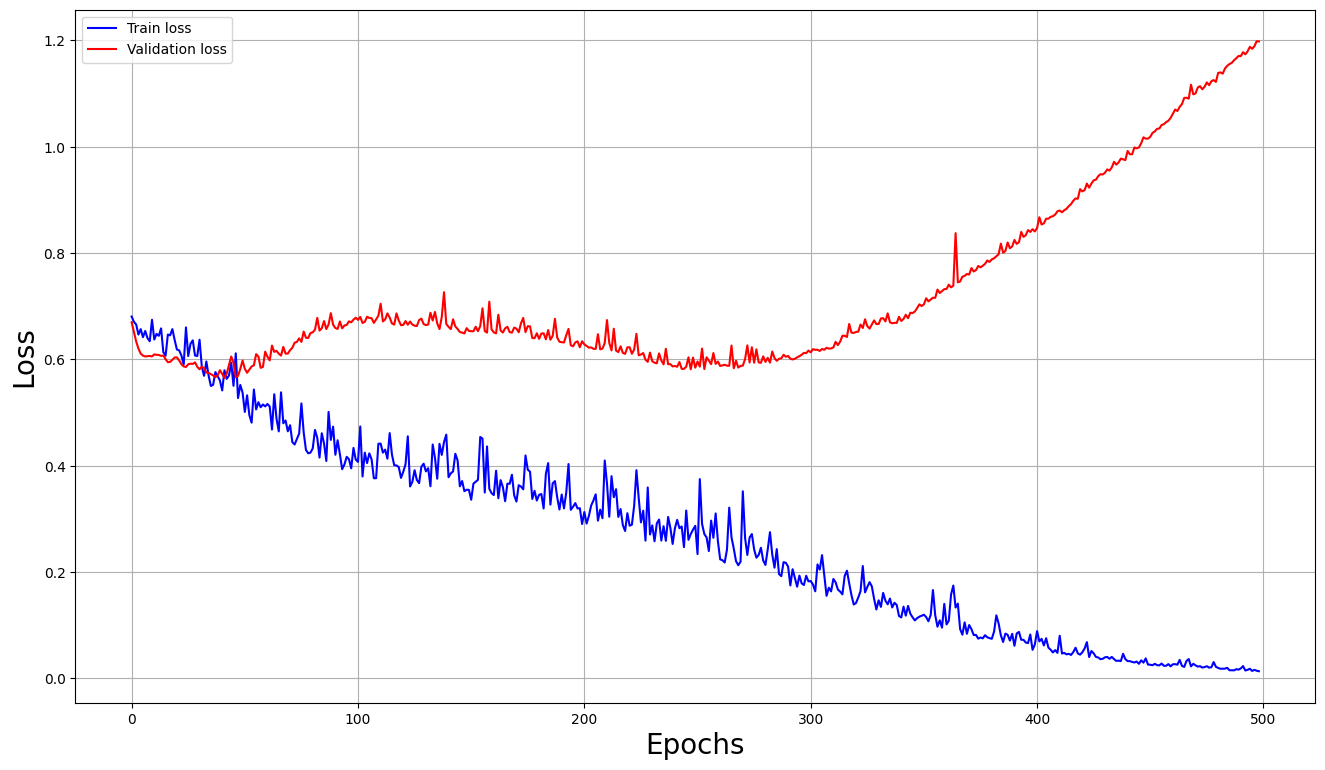

In [69]:
plt.figure(figsize=(16,9))
plt.plot(epoch_train_loss, c='b', label='Train loss')
plt.plot(epoch_val_loss, c='r', label = 'Validation loss')
plt.legend()
plt.grid()
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Loss', fontsize=20)

In [75]:
from sklearn.metrics import accuracy_score, f1_score

# Switch to evaluation mode
model.eval()

# Lists to store predictions and true labels
outputs = []
y_true = []

# Disable gradient calculation for evaluation
with torch.no_grad():
    mri_dataset.mode = 'val'  # Use the validation set
    for D in val_dataloader:
        image = D['image'].to(device)
        label = D['label'].to(device)

        y_hat = model(image)
        outputs.append(y_hat.cpu().detach().numpy())  # Append predictions
        y_true.append(label.cpu().detach().numpy())    # Append true labels

# Concatenate all predictions and true labels
outputs = np.concatenate(outputs, axis=0).squeeze()
y_true = np.concatenate(y_true, axis=0).squeeze()

# Define a function to apply a threshold on the predictions
def threshold(scores, threshold=0.50, minimum=0, maximum=1.0):
    x = np.array(list(scores))
    x[x >= threshold] = maximum
    x[x < threshold] = minimum
    return x

# Apply threshold on the outputs
y_pred = threshold(outputs)

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Calculate F1 score
f1 = f1_score(y_true, y_pred)
print(f'F1 Score: {f1:.2f}')


Accuracy: 0.82
F1 Score: 0.87


# test 

In [80]:
import os
from PIL import Image
from torchvision import transforms

In [90]:
# Set the path to the uploads folder
uploads_folder = './Testing/notumor'

# Define image preprocessing (should match the preprocessing used during training)
preprocess = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to the same size as used in training
    transforms.ToTensor(),          # Convert to Tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalization (mean and std of ImageNet)
])

# Load and preprocess the .jpg images from the uploads folder
def load_jpg_images(folder):
    images = []
    filenames = []
    
    for filename in os.listdir(folder):
        if filename.endswith('.jpg'):
            filepath = os.path.join(folder, filename)
            image = Image.open(filepath).convert('RGB')  # Open the image and convert to RGB
            image_tensor = preprocess(image)
            images.append(image_tensor)
            filenames.append(filename)
    
    return images, filenames

# Load images
images, filenames = load_jpg_images(uploads_folder)

# Ensure the model is in evaluation mode
model.eval()

# Prepare to store outputs
outputs = []

# Perform predictions on the loaded images
with torch.no_grad():
    for image in images:
        image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device (GPU/CPU)
        output = model(image)
        outputs.append(output.cpu().detach().numpy())

# Check if there are outputs before concatenating
if len(outputs) > 0:
    # Convert outputs to probabilities and apply threshold
    outputs = np.concatenate(outputs, axis=0).squeeze()

    # Define a function to apply threshold
    def threshold(scores, threshold=0.50, minimum=0, maximum=1.0):
        x = np.array(list(scores))
        x[x >= threshold] = maximum
        x[x < threshold] = minimum
        return x

    # Apply threshold on predictions
    y_pred = threshold(outputs)

    # Initialize counters
    healthy_count = 0
    tumor_positive_count = 0

    # Print predictions and count "Tumor positive" or "Healthy"
    for i, filename in enumerate(filenames):
        if y_pred[i] == 1.0:
            label = "Tumor positive"
            tumor_positive_count += 1
        else:
            label = "Healthy"
            healthy_count += 1
        
        print(f'File: {filename}, Prediction: {label}')

    # Print total counts
    print(f'\nTotal Tumor positive cases: {tumor_positive_count}')
    print(f'Total Healthy cases: {healthy_count}')

    # Calculate accuracy
    total_images = len(filenames)
    correct_predictions = healthy_count  # All images are healthy in this set
    accuracy = correct_predictions / total_images if total_images > 0 else 0

    # Print accuracy
    print(f'Accuracy: {accuracy * 100:.2f}%')

else:
    print("No outputs were generated. Check if the images are loaded and preprocessed correctly.")


File: Te-noTr_0000.jpg, Prediction: Healthy
File: Te-noTr_0001.jpg, Prediction: Healthy
File: Te-noTr_0002.jpg, Prediction: Healthy
File: Te-noTr_0003.jpg, Prediction: Healthy
File: Te-noTr_0004.jpg, Prediction: Healthy
File: Te-noTr_0005.jpg, Prediction: Healthy
File: Te-noTr_0006.jpg, Prediction: Healthy
File: Te-noTr_0007.jpg, Prediction: Healthy
File: Te-noTr_0008.jpg, Prediction: Healthy
File: Te-noTr_0009.jpg, Prediction: Healthy
File: Te-no_0010.jpg, Prediction: Healthy
File: Te-no_0011.jpg, Prediction: Tumor positive
File: Te-no_0012.jpg, Prediction: Tumor positive
File: Te-no_0013.jpg, Prediction: Healthy
File: Te-no_0014.jpg, Prediction: Tumor positive
File: Te-no_0015.jpg, Prediction: Healthy
File: Te-no_0016.jpg, Prediction: Healthy
File: Te-no_0017.jpg, Prediction: Healthy
File: Te-no_0018.jpg, Prediction: Healthy
File: Te-no_0019.jpg, Prediction: Healthy
File: Te-no_0020.jpg, Prediction: Healthy
File: Te-no_0021.jpg, Prediction: Healthy
File: Te-no_0022.jpg, Prediction: H